<a href="https://colab.research.google.com/github/cormach/bayesian_stats_by_b_lambert/blob/master/Chapter_16_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import shutil
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Please use the latest version of CmdStanPy
!pip install --upgrade cmdstanpy

ERROR: fbprophet 0.6 has requirement cmdstanpy==0.4, but you'll have cmdstanpy 0.9.5 which is incompatible.
  Found existing installation: cmdstanpy 0.4.0
    Uninstalling cmdstanpy-0.4.0:
      Successfully uninstalled cmdstanpy-0.4.0


In [ ]:
# Install pre-built CmdStan binary
# (faster than compiling from source via install_cmdstan() function)
tgz_file = 'colab-cmdstan-2.23.0.tar.gz'
tgz_url = 'https://github.com/stan-dev/cmdstan/releases/download/v2.23.0/colab-cmdstan-2.23.0.tar.gz'
if not os.path.exists(tgz_file):
    urllib.request.urlretrieve(tgz_url, tgz_file)
    shutil.unpack_archive(tgz_file)

In [ ]:
# Specify CmdStan location via environment variable
os.environ['CMDSTAN'] = './cmdstan-2.23.0'
# Check CmdStan path
from cmdstanpy import CmdStanModel, cmdstan_path
cmdstan_path()

'./cmdstan-2.23.0'

In [ ]:
stan_text = '''data {
    int N;
    int<lower=0> X[N];
}
parameters {
    real<lower=0> mu;
    real<lower=0> kappa;
}
model {
    X ~ neg_binomial_2(mu, kappa);
    mu ~ lognormal(2,1);
    kappa ~lognormal(2,1);    
}
generated quantities {
  int<lower=0> XSim[N];
  for (i in 1:N)
  {XSim[i] <- neg_binomial_2_rng(mu, kappa);}
}'''
with open('stan_file.stan', 'w') as f:
  f.write(stan_text)

In [ ]:
!cat stan_file.stan

data {
    int N;
    int<lower=0> X[N];
}
parameters {
    real<lower=0> mu;
    real<lower=0> kappa;
}
model {
    X ~ neg_binomial_2(mu, kappa);
    mu ~ lognormal(2,1);
    kappa ~lognormal(2,1);    
}
generated quantities {
  int<lower=0> XSim[N];
  for (i in 1:N)
  {XSim[i] <- neg_binomial_2_rng(mu, kappa);}
}

In [ ]:
stan_model = CmdStanModel(stan_file='stan_file.stan')

INFO:cmdstanpy:compiling stan program, exe file: /content/stan_file
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /content/stan_file


In [ ]:
url='https://raw.githubusercontent.com/alexandrahotti/Solutions-to-A-Students-Guide-to-Bayesian-Statistics-by-Ben-Lambert/master/All_data/evaluation_discoveries.csv'
df = pd.read_csv(url, error_bad_lines=False)

In [ ]:
data = {'X':df.discoveries.to_numpy(),'N':df.shape[0] }

In [ ]:
stan_post=stan_model.sample(data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4


In [ ]:
stan_post.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmpbwf68gdx/stan_file-202007120919-1-g6qu51r_.csv, /tmp/tmpbwf68gdx/stan_file-202007120919-2-pmnwhqjb.csv, /tmp/tmpbwf68gdx/stan_file-202007120919-3-nswqu5xb.csv, /tmp/tmpbwf68gdx/stan_file-202007120919-4-a5oqjwz2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /tmp/tmpbwf68gdx/stan_file-202007120919-1-g6qu51r_.csv, /tmp/tmpbwf68gdx/stan_file-202007120919-2-pmnwhqjb.csv, /tmp/tmpbwf68gdx/stan_file-202007120919-3-nswqu5xb.csv, /tmp/tmpbwf68gdx/stan_file-202007120919-4-a5oqjwz2.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [ ]:
stan_post.summary().round(decimals=3).iloc[1:4,:]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
mu,3.116,0.004,0.222,2.765,3.111,3.494,2677.29,2965.63,1.000
kappa,7.056,0.128,4.400,3.293,6.002,13.630,1175.12,1301.67,1.005
XSim[1],3.150,0.036,2.252,0.000,3.000,7.000,3987.55,4417.00,1.000


In [ ]:
stan_sample = stan_post.get_drawset()

In [ ]:
stan_sample.drop(columns=['lp__', 'accept_stat__','stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'mu','kappa'], inplace=True)

In [ ]:
posterior_checks_max =np.amax(stan_sample, axis=1)

In [ ]:
(posterior_checks_max >=12).sum()/float(len(posterior_checks_max))

0.245

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


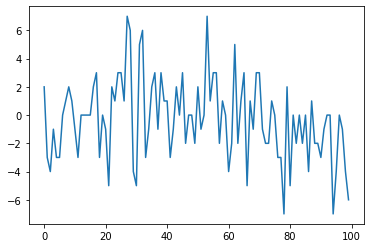

In [ ]:
(df.discoveries-stan_sample['XSim.1']).dropna().plot()

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([ 0.06085919,  0.150358  ,  0.19689737, -0.00477327,  0.00596659,
         0.12291169,  0.1575179 ,  0.13365155, -0.02267303,  0.1372315 ,
         1.        ,  0.1372315 , -0.02267303,  0.13365155,  0.1575179 ,
         0.12291169,  0.00596659, -0.00477327,  0.19689737,  0.150358  ,
         0.06085919]),
 <matplotlib.lines.Line2D at 0x7f467bcf9400>)

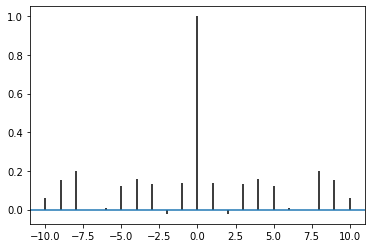

In [ ]:
plt.acorr((df.discoveries-stan_sample['XSim.1']).dropna())